## Implementing the collaborative filtering using deep learning
* Randomly Initialise Parameters — these will be the latent factors that help predict whether someone will like a movie.
* Calculate Predictions — this is done by taking the matrix dot product of the movie and user matrices. An example would be if a user’s likening to international films is high, and a movie is foreign; the product of the two will be large and, that movie will rank higher for that user.
* note: This approach could be used for prediction but is very inefficient as it requires a vector to be created and stored for each prediction.

In [1]:
#libreries
from fastai.collab import *
from fastai.tabular.all import *
from fastai import *
from fastai.metrics import *
from fastai.callback.tracker import *

#import acc from fastai.metrics
from fastai.metrics import accuracy, Precision, Recall
#from fastbook import *
import pandas as pd
import numpy as np
set_seed(42)

In [2]:
df= pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/merged_df.csv')
#use cols userId, wine, rating
df = df[['userId', 'wine', 'rate']]
df.head()

,userId,wine,rate
0,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5
1,d838a526-4b0a-4fad-b54f-90b6ca321fca,Shiraz,2
2,d838a526-4b0a-4fad-b54f-90b6ca321fca,Pinot Noir,3
3,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5
4,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Le Difese,4


In [3]:
# # #importing directly the confusion matrix
# # user_features_df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/user_features_df.csv')
# # user_features_df

# #importing the user,movie,rating dataframe
# #we drop a column that was added by mistake by the system
# df = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/upsampled_df_smote.csv')
# df.head()
# # df = pd.read_csv('/home/bbruno/all_here/python course/thesis/knn/df.csv').drop('Unnamed: 0', axis=1)
# # df.tail()

In [4]:
#we create a dataloader
#we pass the title of the movie and not the movie id
dls = CollabDataLoaders.from_df(df, user_name='userId',item_name='wine', bs=64)
#we can see the batch
dls.show_batch()

,userId,wine,rate
0,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,LFE900,4
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Jurançon Sec,3
2,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Grauvernatsch,3
3,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Mendoza Malbec selected vines,3
4,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montessu,3
5,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Cuvée Imperiale Brut,4
6,91cf68cc-9436-43e1-871d-33beef4d2337,Bubbly Pinot Grigio (Champagne),2
7,5ccd8030-047b-432c-a630-d784ab415756,Weissburgunder Trocken,2
8,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Nebbiolo,2
9,4e9cb62e-a165-484b-ad78-cb215523cdd5,Le sol,5


In [5]:
#CALCULATE PREDICTIONS USING MATRIX MULTIPLICATION

#we create a matrix with the user features
n_users = len(dls.classes['userId']) #the number of user is the lenght of how many users
#we create a matrix with the movie features
n_movies = len(dls.classes['wine']) #the number of movies is the lenght of how many movies
#we choose the number of factors
n_factors = 5 

#we create a random matrix with the user features(embeddings)
#userFactors = (numberOfUsers x 5)
user_factors = torch.randn(n_users, n_factors)
#we create a random matrix with the movie features(embeddings)
#movieFactors = (numberOfMovies x 5)
movie_factors = torch.randn(n_movies, n_factors)

##########################################
#To calculate the result for a particular movie and user combination, 
#we have to look up the index of the movie in our movie latent factor matrix and
#the index of the user in our user latent factor matrix; 
#then we can do our dot product between the two latent factor vectors

# Create a function that takes the user id and the movie title to make a prediction
def oneHotPredict(userId, title):
    '''In the oneHotPredict function, 
    we use the indices of the user and movie in the embedding matrices
    to look up the corresponding embeddings.
    ----
    We calculate the prediction by taking the dot product
    (element-wise multiplication and then sum) of the user and wine embeddings.
    '''
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]
    
    user_embedding = user_factors[userIdx]
    movie_embedding = movie_factors[movie_idx]
    
    prediction = (user_embedding * movie_embedding).sum()
    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

In [6]:
# Prediction for user 9 and the movie 'Toy Story (1995)'
prediction = oneHotPredict('13016d41-00bd-411c-83f5-2b95691696b7', 'Pinot Grigio')
#print(f'Predicted rating for user 9 and Toy Story (1995): {prediction:.2f}')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'Pinot Grigio': -3.41


## Matrix factorization
* A better approach

In [7]:
def create_params(size):
    """
      Pass tensor shape
      Returns normalised model parameters
    """
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

class DotProductBias(Module):
    """
    Model architecture for collaborative filtering
    """
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        """
        Initialises model with parameters
        :param n_users: number of users
        :param n_movies: number of movies
        :param n_factors: number of factors
        :param y_range: sigmoid limit
        """
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        """
        Applies a forward pass on the dataset passed
        :param x: data as DataLoaders obj
        :return: predictions in sigmoid range (tensor)
        """
        users = self.user_factors[x[:, 0]]
        movies = self.movie_factors[x[:, 1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]
        return sigmoid_range(res, *self.y_range)

In [8]:
# from sklearn.model_selection import KFold

# # Assuming dls is your DataLoaders object
# kf = KFold(n_splits=8, shuffle=True, random_state=42)  # You can adjust the number of splits

# # Store the results of each fold
# results = []

# for fold, (train_idx, valid_idx) in enumerate(kf.split(dls.train_ds)):
#     print(f'Fold {fold + 1}')
    
#     # Create new learner for each fold
#     model = DotProductBias(n_users, n_movies, 50)
#     learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mse, rmse, mae])
    
#     # Train the model for a fixed number of epochs
#     learn.fit_one_cycle(10, 5e-3, wd=0.1)
    
#     # Evaluate on the validation set
#     val_metrics = learn.validate(dl=dls.valid)
    
#     # Store the results
#     results.append({
#         'fold': fold + 1,
#         'train_loss': learn.recorder.final_record[0],
#         'valid_loss': val_metrics[0],
#         'mse': val_metrics[1],
#         'rmse': val_metrics[2],
#         'mae': val_metrics[3],
#     })

# # Display the results for each fold
# import pandas as pd
# results_df = pd.DataFrame(results)
# print(results_df)
# # # CV = 8
# # # # acc = 32.84%, train_loss =  1.611755, valid_loss =  1.611755, mse = 1.611755, rmse = 1.269549, mae =  1.014034


#good model
#Working perfectly without cross validation
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
#wd = weight decay (L2 regularization)
learn.fit_one_cycle(10, 0.05, wd=0.1)
# # acc = 34.83% , train_loss = 0.264541, valid_loss = 1.276186, mse = 1.276186, rmse = 1.129684, mae = 0.914164


# #This model generalize good
# model = DotProductBias(n_users, n_movies, 50)
# learn = Learner(dls, model, loss_func=MSELossFlat(),metrics=[mse, rmse, mae])
# #wd = weight decay (L2 regularization)
# learn.fit_one_cycle(10, 0.003, wd=0.1)
# # acc = 32.84% , train_loss = 0.776197, valid_loss = 1.691769, mse = 1.691769, rmse = 1.300680, mae = 1.053445


epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,1.480327,1.860928,1.860928,1.364159,1.126381,00:00
1,1.197594,1.488711,1.488711,1.220127,0.991134,00:00
2,0.897881,1.429315,1.429315,1.195539,0.989657,00:00
3,0.799412,1.350554,1.350554,1.162134,0.954999,00:00
4,0.735804,1.286860,1.286860,1.134398,0.937211,00:00
5,0.631919,1.273412,1.273412,1.128455,0.916631,00:00
6,0.516646,1.281358,1.281358,1.131971,0.918360,00:00
7,0.411755,1.280174,1.280174,1.131448,0.917509,00:00
8,0.327801,1.276468,1.276468,1.129809,0.914542,00:00
9,0.264541,1.276186,1.276186,1.129684,0.914164,00:00


SuggestedLRs(valley=0.005248074419796467)

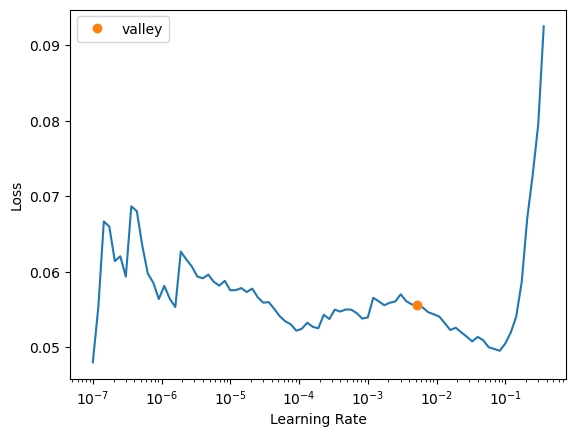

In [9]:
learn.lr_find()

In [10]:
#import torch.nn as nn
#Recommendations
def recommends(fav_movie, top_n=5):
    movie_factors = learn.model.movie_factors
    #we look up the movie in the movie factors
    idx = dls.classes['wine'].o2i[fav_movie]
    #find the movie with minimum distance
    distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
    #we sort the movies by distance
    idx = distances.argsort(descending=True)[1:top_n+1]
    #we return the movies
    recommended_movies = [dls.classes['wine'][i] for i in idx]
    return recommended_movies

recommended_movies = recommends('Pinot Grigio')
print("Recommended movies:")
for movie in recommended_movies:
    print(movie)

Recommended movies:
Refosco dal peduncolo rosso
Brunello di Montalcino Riserva Vigna Paganelli
Brachetto Piemonte
Ribolla Cormons
Bourgogne Aligoté


In [11]:
#def prediction for a user
def prediction_user_like(userId, title):
    userIdx = dls.classes['userId'].o2i[userId]
    movie_idx = dls.classes['wine'].o2i[title]

    # Make a prediction using the model's forward method
    prediction = learn.model.forward(tensor([[userIdx, movie_idx]])).item()

    return print(f"Predicted rating for user '{userId}' and '{title}': {prediction:.2f}")

prediction = prediction_user_like('13016d41-00bd-411c-83f5-2b95691696b7', 'chardonnay')
prediction = prediction_user_like(50, 'cabernet sauvignon')

Predicted rating for user '13016d41-00bd-411c-83f5-2b95691696b7' and 'chardonnay': 3.14
Predicted rating for user '50' and 'cabernet sauvignon': 2.78


In [12]:
# Show 20 rows of results
learn.show_results(n=20)

,userId,wine,rate,rate_pred
0,6,586,4,3.307004
1,106,319,2,2.693024
2,179,652,3,3.148665
3,35,351,5,3.429943
4,22,505,5,3.420377
5,35,448,2,4.102626
6,132,126,5,3.131067
7,88,574,4,3.121006
8,75,533,4,3.726061


In [13]:
g = df.groupby('wine')['rate'].count()
top_wines = g.sort_values(ascending=False).index.values[:50]
top_wines[:10]

array(['Chardonnay', 'Terrano', 'Amarone', 'Pinot Grigio',
       'Vitovska acciaio', 'Pinot Noir', 'Merlot', 'Sauvignon Blanc',
       'Cabernet Sauvignon', 'Cabernet Franc'], dtype=object)

In [14]:
from fastai.metrics import rmse

# Get predictions and targets
preds, targs = learn.get_preds()

# Calculate RMSE
error = rmse(preds, targs)
print(f'RMSE: {error}')

#MSE
error2 = mse(preds, targs)
print(f'MAE: {error2}')

#MAE
error3 = mae(preds, targs)
print(f'MAE: {error3}')

print(preds.shape)
print(targs.shape)

#transform the trags since they were a 2d tensor
targs = targs.squeeze()

#we create a dataframe with the predictions and the targets
df = pd.DataFrame({ 'targets': targs,'predictions': preds})
df.head(20)

#check the error
df['error'] = df['predictions'] - df['targets']


#print the error of the model
print(f"The error is : {df['error'].abs().mean()}")

df


RMSE: 1.1296840906143188
MAE: 1.2761861085891724
MAE: 0.9141635298728943
torch.Size([201])
torch.Size([201, 1])
The error is : 0.9141635298728943


,targets,predictions,error
0,3,3.193975,0.193975
1,4,2.732409,-1.267591
2,3,3.307597,0.307597
3,5,3.166895,-1.833105
4,4,3.122089,-0.877911
...,...,...,...
196,3,2.788917,-0.211083
197,5,3.426399,-1.573601
198,5,3.131067,-1.868933
199,4,3.186515,-0.813485


In [15]:
#sort by best predictions and worst predictions
#sort col error from 0 to 5(-5)

df['abs_error'] = df['error'].abs()
best_predictions = df.sort_values(by='abs_error', ascending=True)
worst_predictions = df.sort_values(by='error', ascending=False)

#best predictions
best_predictions.head(10)

,targets,predictions,error,abs_error
67,3,3.000334,0.000334,0.000334
7,3,3.000742,0.000742,0.000742
56,3,2.966189,-0.033811,0.033811
178,4,4.061482,0.061482,0.061482
121,3,2.935622,-0.064378,0.064378
177,3,3.078060,0.078060,0.078060
78,4,3.921699,-0.078301,0.078301
154,3,3.079711,0.079711,0.079711
54,2,2.086679,0.086679,0.086679
50,3,3.101059,0.101059,0.101059


In [16]:
worst_predictions.head(10)

,targets,predictions,error,abs_error
188,1,4.233399,3.233399,3.233399
99,2,4.102626,2.102626,2.102626
35,1,2.762816,1.762816,1.762816
42,2,3.493657,1.493657,1.493657
47,2,3.242580,1.242580,1.242580
87,2,3.157385,1.157385,1.157385
105,3,4.131993,1.131993,1.131993
181,4,5.115885,1.115885,1.115885
30,2,3.093179,1.093179,1.093179
59,2,3.079745,1.079745,1.079745


In [17]:
def get_accuracy(df):
    # Count correct predictions
    correct = 0
    for _, row in df.iterrows():
        if round(row['predictions']) == round(row['targets']):
            correct += 1

    # Compute accuracy
    accuracy_percentage = correct / len(df)
    return accuracy_percentage * 100

# Get accuracy
accuracy = get_accuracy(df)
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 34.83%


In [18]:
preds, targs = learn.get_preds()

# Now you can check their shapes
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([201])
Targets shape: torch.Size([201, 1])


In [19]:
# Remove the extra dimension from targets
targs = targs.squeeze()

# Now the shapes should match
print(f'Predictions shape: {preds.shape}')
print(f'Targets shape: {targs.shape}')

Predictions shape: torch.Size([201])
Targets shape: torch.Size([201])


In [20]:
# Assuming `dls` is your DataLoader
for i, batch in enumerate(dls.valid):
    x, y = batch
    print(f'Batch {i+1}: {x.shape[0]}')

# Check the shape of predictions and targets
print(f'Predictions: {preds.shape[0]}')
print(f'Targets: {targs.shape[0]}')

Batch 1: 64
Batch 2: 64
Batch 3: 64
Batch 4: 9
Predictions: 201
Targets: 201


In [21]:
print(f'Predictions: {preds.shape}')
print(f'Targets: {targs.shape}')

Predictions: torch.Size([201])
Targets: torch.Size([201])
